# Load Functions

In [1]:
import itertools
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import mdtraj as md
import numpy as np
import seaborn as sns
import os
import pickle
from enspara import ra
from enspara.msm import msm, builders, transition_matrices
from functools import partial
import scipy.stats

import pandas as pd
import pickle

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
sns.set_style("white")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['xtick.labelsize'] = 19
plt.rcParams['ytick.labelsize'] = 19
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['errorbar.capsize'] = 3.0

wtc='#5050fb'
nepc='#52007a'
C13Sc='#9696ff'
C24Sc='#9676af'

In [3]:
def make_histogram(data, pop_vals, n_bins, min_val, max_val):
    freq, edges =np.histogram(data, bins=n_bins, weights = pop_vals,
                             range = (min_val, max_val))
    xvals = (edges[1:] + edges[:-1]) / 2 
    return freq,xvals

def plot_1dhistogram(xvals, freq, sigma_val, color_string):
    F_vals = gaussian_filter1d(freq, sigma=sigma_val)
    plt.plot(xvals, F_vals, lw=1.75, color=xkcd_rgb[color_string])
    plt.tight_layout()
    return F_vals

def plot_wErrorbars(xvals, yvals, yerr_vals, color_string, label_name):
    plt.errorbar(xvals, yvals, yerr=yerr_vals, color=xkcd_rgb[color_string], label=label_name)
    plt.tight_layout()


def plot_wError_Range(xvals, yvals, yerr_vals, color_string, label_name):
    plt.fill_between(xvals, y1 = yvals - yerr_vals, y2 = yvals+yerr_vals,
                     color=xkcd_rgb[color_string], alpha=0.4, zorder=1)
    plt.plot(xvals, yvals, color=xkcd_rgb[color_string], label=label_name, zorder=2)
    plt.tight_layout()
    
def calc_distance(trajectory, residues, atom_names,min_avg):
    apairs=[np.concatenate([trajectory.top.select("resSeq %d and (%s)" % (i, atom_names))
                           for i in r]) for r in residues]
    apairs=list(itertools.product(apairs[0], apairs[1]))
    adists=md.compute_distances(trajectory, atom_pairs=apairs)
    if min_avg=="average":
        dists=adists.mean(axis=1)
    elif min_avg=="minn":
        dists=np.amin(adists, axis=1)
    return dists

In [4]:
def convert_Hbond_to_residue_bond(Topology, Hbonds):
    #Converts output from md.wernet_nilsson into a ragged list (frames) of lists (bonds in frame)
    #of lists (residues involved in bond) and returns the residue number list. Residue corresponds to the
    #numbering in the topology file.
    residue_bonds=[]
    for frame in range(len(Hbonds)):
        tmpframelist=[]
        for bond in range(len(Hbonds[frame])):
            templist=[0,0]
            templist[0]=Topology.atom(Hbonds[frame][bond][0]).residue.resSeq
            templist[1]=Topology.atom(Hbonds[frame][bond][2]).residue.resSeq
            tmpframelist.append(templist)
        residue_bonds.append(tmpframelist)
        
    return residue_bonds

def check_bond_status(residue_bonds, bond_pairs_list, strict_search):
#Iterates through the frames of a Hbond residue list and checks if a bond exists in each frame.
#Returns a mask array of length frames.

#If strict_search=True, residues provided must be in order of H-bond donor, H-bond acceptor,
#If strict_search=False, residue order is irrelevant

#Initialize a storage array that is of length bonds to check by frames.

    masked_bonds=np.zeros((len(bond_pairs_list),len(residue_bonds)))
    bond_pair_index=0

    #For each frame, check whether the bond-pair exists
    if strict_search==True:
        for potential_bond in bond_pairs_list:
            for frame in range(len(residue_bonds)):
                if potential_bond in residue_bonds[frame]:
                    masked_bonds[bond_pair_index, frame]=1
            bond_pair_index+=1

    else:  
        for potential_bond in bond_pairs_list:
            for frame in range(len(residue_bonds)):
                if potential_bond in residue_bonds[frame] or potential_bond[::-1] in residue_bonds[frame]:
                    masked_bonds[bond_pair_index, frame]=1
            bond_pair_index+=1
    return masked_bonds

def is_resi_bonded(residue_bonds, residue):
#Iterates through the frames of a Hbond residue list and checks if a bond exists in each frame.
#Returns a mask array of length frames.

#Initialize a storage array that is of length bonds to check by frames.

    masked_bonds=np.zeros((len(residue_bonds)))
    
    #For each frame, check whether the bond-pair exists
    for frame in range(len(residue_bonds)):
        if any(residue in sublist for sublist in residue_bonds[frame]):
            masked_bonds[frame]=1

    return masked_bonds

In [5]:
def rmsf_calc(centers, ref_frame=0):
    """Calculated the RMSF from a frame in a MSM

    Attributes
    ----------
    centers : md.trajectory, shape=(n_states,),
        The cluster centers to use for RMSF calculations.
    ref_frame : int, default=0,
        The reference state in the MSM to use for calculation
        deviations from. If not supplied, first frame is used.

    Returns
    ----------
    rmsfs : nd.array, shape=(n_frames,n_residues),
        Returns the RMSF of each residue for each frame.
    """
    # align all states to reference frame
    centers = centers.superpose(centers[ref_frame])

    # get differences between coordinates
    diffs = centers.xyz - centers.xyz[ref_frame]

    # dot product differences
    dists_per_atom_sq = np.einsum('ijk,ijk->ij', diffs, diffs)

    # obtain indices of all atoms partitioned by residues
    atom_iis_per_resi = np.array(
        [[a.index for a in r.atoms] for r in centers.top.residues])

    # average the dot products within each residue
    avg_resi_dists = np.array(
        [
            np.mean(dists_per_atom_sq[:, iis], axis=1)
            for iis in atom_iis_per_resi])
    rmsfs=np.transpose(avg_resi_dists)

    return rmsfs


In [6]:
def find_chi_angles(chi1_array, chi2_array, topfile, residue_of_interest):
    #First find the atom index of the CA (CAs are involved in chi1/chi2 bond definitions!)
    CA_index=topfile.select(f"resSeq {residue_of_interest} and name CA")
    #Chi1/2 arrays are saved as following: [(chi angles (variable based on residue IDs, 4 atom indices))/
    #,(nframes, n chi_angles)]
    chi1s=(chi1_array[1][:,np.where(chi1_array[0]==CA_index)[0]].flatten())
    chi2s=(chi2_array[1][:,np.where(chi2_array[0]==CA_index)[0]].flatten())
    chis=np.array([chi1s, chi2s])
    return chis

# Import Data

In [7]:
d='/home/jjmiller/bowmore/jjmiller/Simulations/PlasmepsinV/MSMs'
Top_WT=d+'/WT-prot-masses.pdb'
Top_Ser1=d+'/Ser1-prot-masses.pdb'
Top_Ser2=d+'/Ser2-prot-masses.pdb'
Top_Nep_mut=d+'/NepMut-prot-masses.pdb'

In [8]:
centersWT=md.load('./WT_center_structures.xtc',top=Top_WT)
centersNep=md.load('./Nep_center_structures.xtc',top=Top_Nep_mut)
centersSer1=md.load('./Ser1_center_structures.xtc',top=Top_Ser1)
centersSer2=md.load('./Ser2_center_structures.xtc',top=Top_Ser2)

In [9]:
#Bootstrapped the eq_probs by resampling the assignments file iteratively excluding a trajectory
bs_wt_pops=np.load('./bootstrapping/strap_output_WT_lagtime250_eqpops.npy')
bs_nep_pops=np.load('./bootstrapping//strap_output_Nep_lagtime250_eqpops.npy')
bs_ser1_pops=np.load('./bootstrapping//strap_output_Ser1_lagtime250_eqpops.npy')
bs_ser2_pops=np.load('./bootstrapping//strap_output_Ser2_lagtime250_eqpops.npy')

In [10]:
popsWT=np.mean(bs_wt_pops,axis=0)
popsNep=np.mean(bs_nep_pops,axis=0)
popsSer1=np.mean(bs_ser1_pops,axis=0)
popsSer2=np.mean(bs_ser2_pops,axis=0)

In [11]:
def histonorm(values, nbins, weights, histrange):
    counts_vals, bins_vals=np.histogram(values, bins=nbins, weights=weights, range=histrange)
    normcounts=counts_vals/sum(counts_vals)
    return normcounts, bins_vals

## How does the RMSF of the loop change?

In [12]:
WTtop=md.load(Top_WT).topology
Ser1top=md.load(Top_Ser1).topology
Ser2top=md.load(Top_Ser2).topology
Neptop=md.load(Top_Nep_mut).topology
WT_aligned=md.load('.//wt_aligned.xtc', top=WTtop)
Ser1_aligned=md.load('.//ser1_aligned.xtc', top=Ser1top)
Ser2_aligned=md.load('.//ser2_aligned.xtc', top=Ser2top)
Nep_aligned=md.load('.//nep_aligned.xtc', top=Neptop)

In [13]:
#Calculate the residue RMSF by frame
rmsfs_wt=rmsf_calc(WT_aligned)
rmsfs_ser1=rmsf_calc(Ser1_aligned)
rmsfs_ser2=rmsf_calc(Ser2_aligned)
rmsfs_nep=rmsf_calc(Nep_aligned)

/home/jjmiller/modules/yes/envs/condaenvir/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [14]:
#Select the loop residues
WT_loop_indcs=WTtop.select('(resSeq 153 to 173) and backbone')
Ser1_loop_indcs=Ser1top.select('(resSeq 153 to 173) and backbone')
Ser2_loop_indcs=Ser2top.select('(resSeq 153 to 173) and backbone')
Nep_loop_indcs=Neptop.select('(resSeq 153 to 175) and backbone')

In [15]:
wt_loop_rmsf=(np.mean(rmsfs_wt[:,70:90],axis=1))
ser1_loop_rmsf=(np.mean(rmsfs_ser1[:,70:90],axis=1))
ser2_loop_rmsf=(np.mean(rmsfs_ser2[:,70:90],axis=1))
nep_loop_rmsf=(np.mean(rmsfs_nep[:,71:93],axis=1))

In [16]:
numbins=50
historange=(0,1.0)

normCountsWT,binsWT= histonorm(wt_loop_rmsf, numbins, popsWT, historange)
normCountsNep, binsNep= histonorm(nep_loop_rmsf, numbins, popsNep, historange)
normCountsSer1, binsSer1= histonorm(ser1_loop_rmsf, numbins, popsSer1, historange)
normCountsSer2, binsSer2= histonorm(ser2_loop_rmsf, numbins, popsSer2, historange)

binscenters_WT=(binsWT[:-1] + binsWT[1:]) / 2
width=binsWT[1]-binsWT[0]

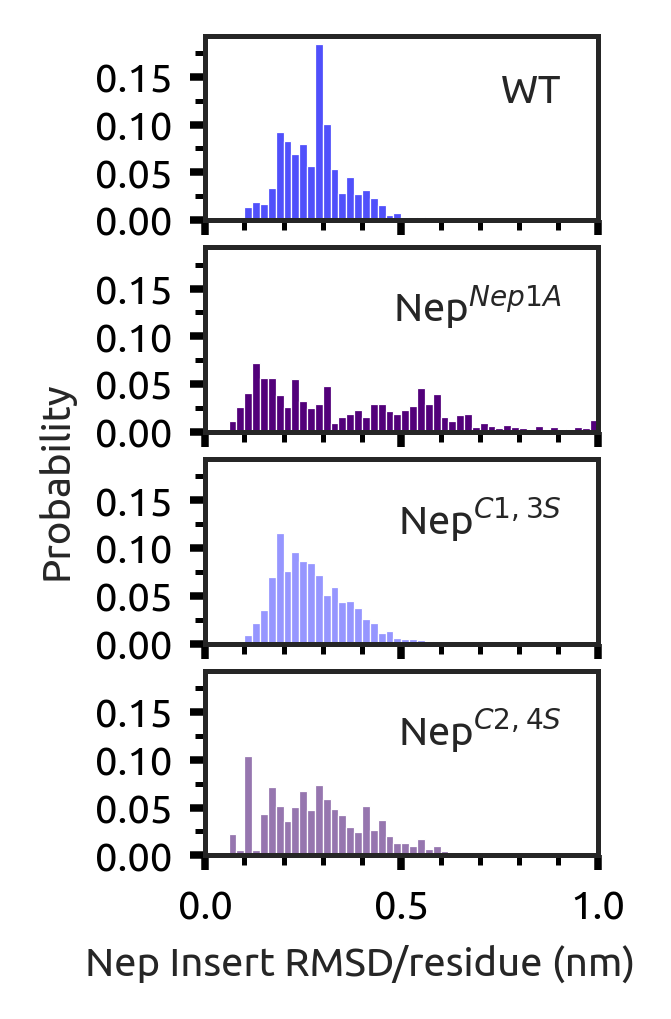

In [17]:
fig, axs=plt.subplots(4,1,sharey=True, sharex=True, figsize=(1.5,2.5), dpi=360)
fig.text(-0.1, 0.5, 'Probability', va='center',rotation='vertical', fontsize=8)
fig.text(0.5, -0.05, 'Nep Insert RMSD/residue (nm)', ha='center',fontsize=8)
plt.xlim(0, 1.0)
axs[0].bar(binscenters_WT,normCountsWT, align='center', width=width, label="WT", color=wtc,linewidth=0.25)
axs[1].bar(binscenters_WT,normCountsNep, align='center', width=width, label="Nep$^{Nep1A}$", color=nepc,linewidth=0.25)
axs[2].bar(binscenters_WT,normCountsSer1, align='center', width=width, label="Nep$^{C1,3S}$", color=C13Sc,linewidth=0.25)
axs[3].bar(binscenters_WT,normCountsSer2, align='center', width=width, label="Nep$^{C2,4S}$", color=C24Sc,linewidth=0.25)

for ax in axs:
    ax.legend(fontsize=8,frameon=False, loc='upper right', handlelength=0, handletextpad=0, fancybox=True)
    ax.get_xticklabels()    
    ax.tick_params(which='major', direction='out', length=3, width=1.5, colors='black')
    ax.tick_params(which='minor', direction='out', length=2, width=1, colors='black')

    ax.xaxis.set_major_locator(MultipleLocator(.5))
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.025))
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    
    ax.tick_params(axis = 'x', which = 'both', bottom = True, top=False, labelsize=8)
    ax.tick_params(axis= 'y', which = 'both', left = True, right=False, labelsize=8)
fig.tight_layout(pad=0.05)
plt.savefig('./Figures/Nep_insert_RMSD_smaller.svg')
plt.show()

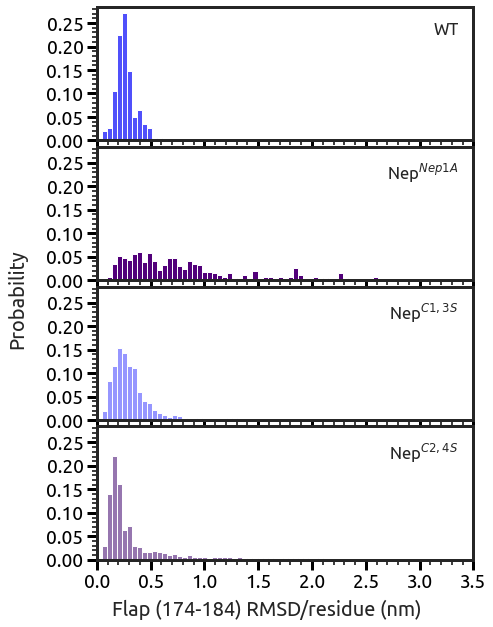

In [18]:
#RMSF of the FLAP?
wt_flap_rmsf=(np.mean(rmsfs_wt[:,91:101],axis=1))
ser1_flap_rmsf=(np.mean(rmsfs_ser1[:,91:101],axis=1))
ser2_flap_rmsf=(np.mean(rmsfs_ser2[:,91:101],axis=1))
nep_flap_rmsf=(np.mean(rmsfs_nep[:,94:104],axis=1))

numbins=75
historange=(0,3.5)

normCountsWT,binsWT= histonorm(wt_flap_rmsf, numbins, popsWT, historange)
normCountsNep, binsNep= histonorm(nep_flap_rmsf, numbins, popsNep, historange)
normCountsSer1, binsSer1= histonorm(ser1_flap_rmsf, numbins, popsSer1, historange)
normCountsSer2, binsSer2= histonorm(ser2_flap_rmsf, numbins, popsSer2, historange)

binscenters_WT=(binsWT[:-1] + binsWT[1:]) / 2
width=binsWT[1]-binsWT[0]

fig, axs=plt.subplots(4,1,sharey=True, sharex=True, figsize=(6,8))
fig.text(-0.1, 0.5, 'Probability', va='center',rotation='vertical')
fig.text(0.5, -0.05, 'Flap (174-184) RMSD/residue (nm)', ha='center',)
plt.xlim(0, 3.5)
axs[0].bar(binscenters_WT,normCountsWT, align='center', width=width, label="WT", color=wtc)
axs[1].bar(binscenters_WT,normCountsNep, align='center', width=width, label="Nep$^{Nep1A}$", color=nepc)
axs[2].bar(binscenters_WT,normCountsSer1, align='center', width=width, label="Nep$^{C1,3S}$", color=C13Sc)
axs[3].bar(binscenters_WT,normCountsSer2, align='center', width=width, label="Nep$^{C2,4S}$", color=C24Sc)

for ax in axs:
    ax.legend(fontsize='small',frameon=False, loc='upper right', handlelength=0, handletextpad=0, fancybox=True)
    ax.get_xticklabels()    
    ax.tick_params(which='major', direction='out', length=10, width=3, colors='black')
    ax.tick_params(which='minor', direction='out', length=5, width=1.5, colors='black')

    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    
    ax.tick_params(axis = 'x', which = 'both', bottom = True, top=False)
    ax.tick_params(axis= 'y', which = 'both', left = True, right=False)
fig.tight_layout(pad=-0.2)
plt.show()

# How is flap opening impacted?

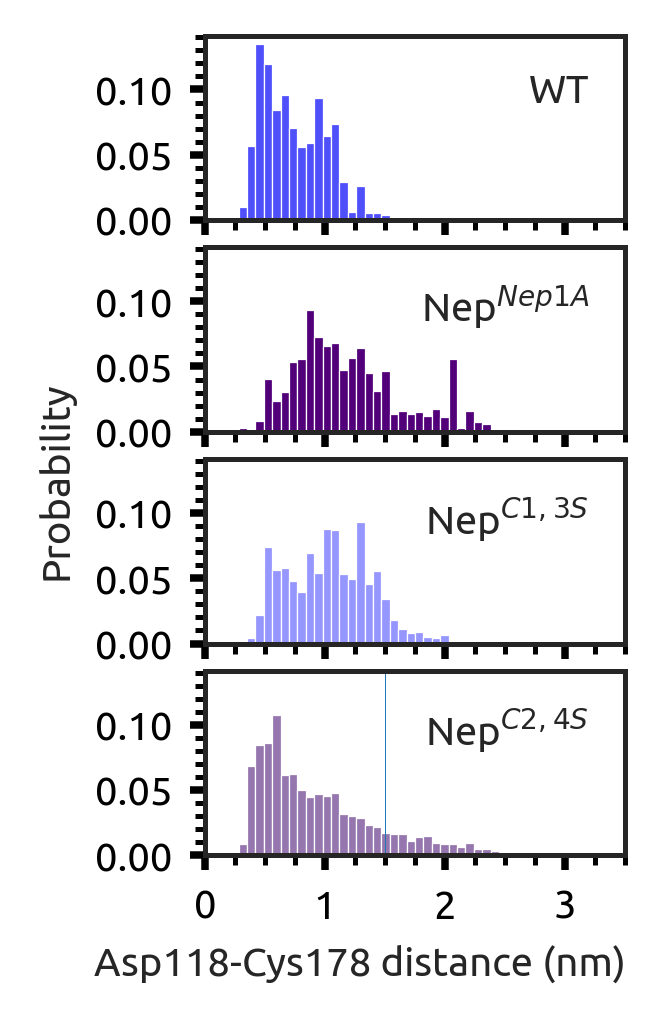

In [19]:
#Use the distance between D118 and Cys178 (WT) as a metric of flap opening
WT_FLAP=calc_distance(centersWT,[[118],[178]],"sidechain","minn")
NepMutFLAP=calc_distance(centersNep,[[118],[180]],"sidechain","minn")
Ser1FLAP=calc_distance(centersSer1,[[118],[178]],"sidechain","minn")
Ser2FLAP=calc_distance(centersSer2,[[118],[178]],"sidechain","minn")
# NepTruncFLAP=calc_distance(NepTruncTrjs,[[37],[97]],"protein")


numbins=50
historange=(0,3.5)

normCountsWT,binsWT= histonorm(WT_FLAP, numbins, popsWT, historange)
normCountsNep, binsNep= histonorm(NepMutFLAP, numbins, popsNep, historange)
normCountsSer1, binsSer1= histonorm(Ser1FLAP, numbins, popsSer1, historange)
normCountsSer2, binsSer2= histonorm(Ser2FLAP, numbins, popsSer2, historange)

binscenters_WT=(binsWT[:-1] + binsWT[1:]) / 2
width=binsWT[1]-binsWT[0]

fig, axs=plt.subplots(4,1,sharey=True, sharex=True, figsize=(1.5,2.5), dpi=360)
fig.text(-0.1, 0.5, 'Probability', va='center',rotation='vertical',fontsize=8)
fig.text(0.5, -0.05, 'Asp118-Cys178 distance (nm)', ha='center',fontsize=8)
plt.xlim(0,3.5)
axs[0].bar(binscenters_WT,normCountsWT, align='center', width=width, label="WT", color=wtc, linewidth=0.25)
axs[1].bar(binscenters_WT,normCountsNep, align='center', width=width, label="Nep$^{Nep1A}$", color=nepc, linewidth=0.25)
axs[2].bar(binscenters_WT,normCountsSer1, align='center', width=width, label="Nep$^{C1,3S}$", color=C13Sc, linewidth=0.25)
axs[3].bar(binscenters_WT,normCountsSer2, align='center', width=width, label="Nep$^{C2,4S}$", color=C24Sc, linewidth=0.25)

for ax in axs:
    ax.legend(fontsize=8,frameon=False, loc='upper right', handlelength=0, handletextpad=0, fancybox=True)
    ax.get_xticklabels()    
    ax.tick_params(which='major', direction='out', length=3, width=1.5, colors='black')
    ax.tick_params(which='minor', direction='out', length=2, width=1, colors='black')

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)    
    
    ax.tick_params(axis = 'x', which = 'both', bottom = True, top=False,labelsize=8)
    ax.tick_params(axis= 'y', which = 'both', left = True, right=False,labelsize=8)
fig.tight_layout(pad=0.05)
plt.axvline(x=1.5,lw=0.2)

In [20]:
cutoff=1.5
wt_indcs=np.where(WT_FLAP>cutoff)
nep_indcs=np.where(NepMutFLAP>cutoff)
s1_indcs=np.where(Ser1FLAP>cutoff)
s2_indcs=np.where(Ser2FLAP>cutoff)

wt_vals=[np.sum(bs_wt_pops[i][wt_indcs]) for i in range(len(bs_wt_pops))]
nep_vals=[np.sum(bs_nep_pops[i][nep_indcs]) for i in range(len(bs_nep_pops))]
s1_vals=[np.sum(bs_ser1_pops[i][s1_indcs]) for i in range(len(bs_ser1_pops))]
s2_vals=[np.sum(bs_ser2_pops[i][s2_indcs]) for i in range(len(bs_ser2_pops))]

print("WT Extra Open Active Site % is:", (100*np.mean(wt_vals)), "+/-", 100*np.std(wt_vals), "%")
print("Nep Mut Extra Open Active Site % is:", (100*np.mean(nep_vals)), "+/-", 100*np.std(nep_vals), "%")
print("Ser 1 Extra Open Active Site % is:", (100*np.mean(s1_vals)), "+/-", 100*np.std(s1_vals), "%")
print("Ser 2 Extra Open Active Site % is:", (100*np.mean(s2_vals)), "+/-", 100*np.std(s2_vals), "%")

WT Extra Open Active Site % is: 0.6872264650250091 +/- 0.14710123335130865 %
Nep Mut Extra Open Active Site % is: 20.96680928977383 +/- 5.744351028251319 %
Ser 1 Extra Open Active Site % is: 8.938057158839786 +/- 2.024481444477831 %
Ser 2 Extra Open Active Site % is: 14.246168936621023 +/- 4.473128481283297 %


In [21]:
#Iterate through a series of distances to pull out the maximum likely structure for each range.

opening_distances=(np.arange(0.25,2,.125))
save_structures=False


for i in range(len(opening_distances)-1):
    print(opening_distances[i],"-",opening_distances[i+1])
    print("center:", np.where(popsWT==np.amax(popsWT[np.where((WT_FLAP>opening_distances[i]) & (WT_FLAP<opening_distances[i+1]))]))[0][0])
    centerindex=np.where(popsWT==np.amax(popsWT[np.where((WT_FLAP>opening_distances[i]) & (WT_FLAP<opening_distances[i+1]))]))[0][0]
    distance=WT_FLAP[centerindex]
    if save_structures==True:
        cmd = f'echo "System" | gmx trjconv -f .//WT_center_structures.xtc -s ../ProcessedRuns/WT-prot-masses.pdb \
        -o Structures_for_Figures/WT_FLAP_Opening/WT_center{i}_open{distance}.pdb -b {centerindex} -e {centerindex}'
        os.system(cmd)

0.25 - 0.375
center: 1018
0.375 - 0.5
center: 1904
0.5 - 0.625
center: 372
0.625 - 0.75
center: 987
0.75 - 0.875
center: 738
0.875 - 1.0
center: 433
1.0 - 1.125
center: 781
1.125 - 1.25
center: 932
1.25 - 1.375
center: 2475
1.375 - 1.5
center: 2728
1.5 - 1.625
center: 2279
1.625 - 1.75
center: 712
1.75 - 1.875
center: 829


In [22]:
collapsed_flaps=np.where((Ser2FLAP<0.4))[0]
print(collapsed_flaps)

save_structures=False
#Optionally save out structures
if save_structures==True:
    for i in collapsed_flaps:
#         cmd = f'echo "System" | gmx trjconv -f WT_center_structures.xtc -s ../ProcessedRuns/WT-prot-masses.pdb \
#         -o Structures_for_Figures/Large_Flap_Opening/WT_center{i}.pdb -b {i} -e {i}'
        
        cmd = f'echo "System" | gmx trjconv -f Ser2_center_structures.xtc -s ../ProcessedRuns/Ser2-prot-masses.pdb \
        -o Structures_for_Figures/C24S_collapsed_flap/C24S_center{i}.pdb -b {i} -e {i}'
        os.system(cmd)

[  37  251  268  453 1220 1597 1887 2372 2440 2606 2721]


# How closed is the flap?

In [23]:
#Define one set of residues as ResSeq176-181
#Define the other set as ResSeq 485-493
Chain1ids=np.arange(93,99)
Chain2ids=np.arange(402,411)
pairwise_flap_residues=[]
nep_pairwise_flap_residues=[]
for i in Chain1ids:
    for j in Chain2ids:
        pairwise_flap_residues.append([i,j])
        nep_pairwise_flap_residues.append([i+3,j+3])
pairwise_flap_residues=np.array(pairwise_flap_residues)
nep_pairwise_flap_residues=np.array(nep_pairwise_flap_residues)

#Calculate the closest contacts
wt_flap_contacts=md.compute_contacts(centersWT,contacts=pairwise_flap_residues, scheme='closest')
nep_flap_contacts=md.compute_contacts(centersNep, contacts=nep_pairwise_flap_residues, scheme='closest')
ser1_flap_contacts=md.compute_contacts(centersSer1, contacts=pairwise_flap_residues, scheme='closest')
ser2_flap_contacts=md.compute_contacts(centersSer2, contacts=pairwise_flap_residues, scheme='closest')

#Pull out the min flap distance
wtminflap_dist=np.amin(wt_flap_contacts[0], axis=1)
nepminflap_dist=np.amin(nep_flap_contacts[0], axis=1)
ser1minflap_dist=np.amin(ser1_flap_contacts[0], axis=1)
ser2minflap_dist=np.amin(ser2_flap_contacts[0], axis=1)

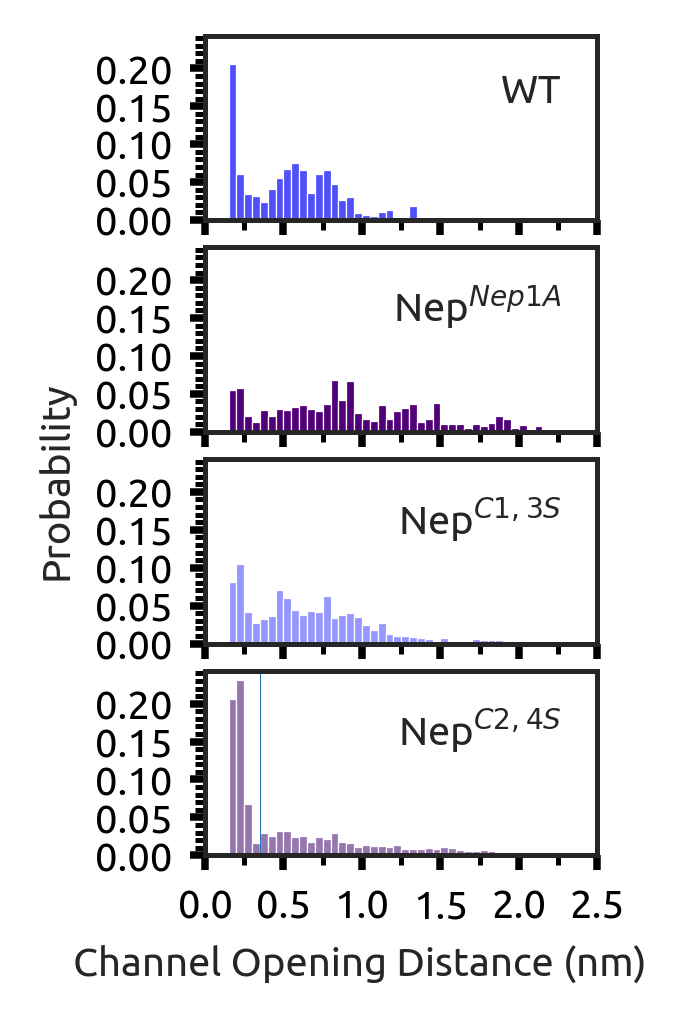

In [24]:
numbins=50
historange=(0,2.5)

normCountsWT,binsWT= histonorm(wtminflap_dist, numbins, popsWT, historange)
normCountsNep, binsNep= histonorm(nepminflap_dist, numbins, popsNep, historange)
normCountsSer1, binsSer1= histonorm(ser1minflap_dist, numbins, popsSer1, historange)
normCountsSer2, binsSer2= histonorm(ser2minflap_dist, numbins, popsSer2, historange)

binscenters_WT=(binsWT[:-1] + binsWT[1:]) / 2
width=binsWT[1]-binsWT[0]


fig, axs=plt.subplots(4,1,sharey=True, sharex=True, figsize=(1.5, 2.5), dpi=360)
fig.text(-0.1, 0.5, 'Probability', va='center',rotation='vertical', fontsize=8)
fig.text(0.5, -0.05, 'Channel Opening Distance (nm)', ha='center', fontsize=8)
plt.xlim(0,2.5)
axs[0].bar(binscenters_WT,normCountsWT, align='center', width=width, label="WT", color=wtc, linewidth=0.25)
axs[1].bar(binscenters_WT,normCountsNep, align='center', width=width, label="Nep$^{Nep1A}$", color=nepc, linewidth=0.25)
axs[2].bar(binscenters_WT,normCountsSer1, align='center', width=width, label="Nep$^{C1,3S}$", color=C13Sc, linewidth=0.25)
axs[3].bar(binscenters_WT,normCountsSer2, align='center', width=width, label="Nep$^{C2,4S}$", color=C24Sc, linewidth=0.25)

for ax in axs:
    ax.legend(fontsize=8,frameon=False, loc='upper right', handlelength=0, handletextpad=0, fancybox=True)
    ax.get_xticklabels()    
    ax.tick_params(which='major', direction='out', length=3, width=1.5, colors='black')
    ax.tick_params(which='minor', direction='out', length=2, width=1, colors='black')

    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)        
    
    ax.tick_params(axis = 'x', which = 'both', bottom = True, top=False, labelsize=8)
    ax.tick_params(axis= 'y', which = 'both', left = True, right=False, labelsize = 8)
fig.tight_layout(pad=0.05)
plt.axvline(x=0.35,lw=0.2)
plt.savefig('./Figures/Channel_Opening_smaller.svg')
plt.show()

In [25]:
# what is the probability of being more closed than nm?
cutoff=0.4
wt_indcs=np.where(wtminflap_dist>cutoff)
nep_indcs=np.where(nepminflap_dist>cutoff)
s1_indcs=np.where(ser1minflap_dist>cutoff)
s2_indcs=np.where(ser2minflap_dist>cutoff)

wt_vals=[np.sum(bs_wt_pops[i][wt_indcs]) for i in range(len(bs_wt_pops))]
nep_vals=[np.sum(bs_nep_pops[i][nep_indcs]) for i in range(len(bs_nep_pops))]
s1_vals=[np.sum(bs_ser1_pops[i][s1_indcs]) for i in range(len(bs_ser1_pops))]
s2_vals=[np.sum(bs_ser2_pops[i][s2_indcs]) for i in range(len(bs_ser2_pops))]

print("WT Closed Active Site % is:", (100*np.mean(wt_vals)), "+/-", 100*np.std(wt_vals), "%")
print("Nep Mut Closed Active Site % is:", (100*np.mean(nep_vals)), "+/-", 100*np.std(nep_vals), "%")
print("Ser 1 Closed Active Site % is:", (100*np.mean(s1_vals)), "+/-", 100*np.std(s1_vals), "%")
print("Ser 2 Closed Active Site % is:", (100*np.mean(s2_vals)), "+/-", 100*np.std(s2_vals), "%")

WT Closed Active Site % is: 64.30847791578528 +/- 7.333870652206922 %
Nep Mut Closed Active Site % is: 82.55699224008805 +/- 4.308769487296378 %
Ser 1 Closed Active Site % is: 71.34258096393201 +/- 4.3125208040784 %
Ser 2 Closed Active Site % is: 44.91990669141524 +/- 10.055061427604201 %


In [26]:
#Iterate through a series of distances to pull out the maximum likely structure for each range.

opening_distances=(np.arange(0,2,.25))
#opening_distances=np.array([0.33,0.37])
save_structures=False


for i in range(len(opening_distances)-1):
    centerindex=np.where(popsWT==np.amax(popsWT[np.where((wtminflap_dist>opening_distances[i]) & (wtminflap_dist<opening_distances[i+1]))]))[0][0]
    distance=np.round(wtminflap_dist[centerindex],3)
    print(opening_distances[i],"-",opening_distances[i+1])
    print("center:", centerindex, "   distance:", distance)

    if save_structures==True:
        cmd = f'echo "System" | gmx trjconv -f WT_center_structures.xtc -s ../ProcessedRuns/WT-prot-masses.pdb \
        -o Structures_for_Figures/channel_opening/WT_center{i}_open{distance}.pdb -b {centerindex} -e {centerindex}'
        os.system(cmd)

0.0 - 0.25
center: 1904    distance: 0.179
0.25 - 0.5
center: 2432    distance: 0.478
0.5 - 0.75
center: 433    distance: 0.553
0.75 - 1.0
center: 781    distance: 0.825
1.0 - 1.25
center: 1029    distance: 1.16
1.25 - 1.5
center: 2475    distance: 1.322
1.5 - 1.75
center: 478    distance: 1.548


## How is Hbonding impacted?

## There are two potential H-donors for the active site serine (125). His (212- NE2) and Gln 177-NE2

In [27]:
WTtop=md.load(Top_WT).topology
Neptop=md.load(Top_Nep_mut).topology
Ser1top=md.load(Top_Ser1).topology
Ser2top=md.load(Top_Ser2).topology

In [28]:
print()
print('WT')
print(WTtop.atom(683))
print(WTtop.atom(1443), WTtop.atom(1443).residue)
print(WTtop.atom(2024))
print()
print('Nep')
print(Neptop.atom(694))
print(Neptop.atom(1464))
print(Neptop.atom(2045))
print()
print('Ser1')
print(Ser1top.atom(683))
print(Ser1top.atom(1445))
print(Ser1top.atom(2026))
print()
print('Ser2')
print(Ser2top.atom(683))
print(Ser2top.atom(1445))
print(Ser2top.atom(2026))


WT
SER125-OG
GLN175-OE1 GLN175
HIS212-NE2

Nep
SER125-OG
GLN177-OE1
HIS214-NE2

Ser1
SER125-OG
GLN175-OE1
HIS212-NE2

Ser2
SER125-OG
GLN175-OE1
HIS212-NE2


In [29]:
#Calculate the Wernet_Nilsson H-bond pairs for each frame in the trajectory
#Returns a jagged array of length of centers, with each center having variable number of bonds.
#For each bond, returns 3 atom indicies of the bond- donor atom, hydrogen atom, acceptor atom
ser1Hbonds=md.wernet_nilsson(centersSer1, sidechain_only=True)
ser2Hbonds=md.wernet_nilsson(centersSer2, sidechain_only=True)
NepHbonds=md.wernet_nilsson(centersNep, sidechain_only=True)
WTHbonds=md.wernet_nilsson(centersWT, sidechain_only=True)

#Convert the atom numbers into residue numbers, drop the H-atom
residue_numbers_ser1=convert_Hbond_to_residue_bond(Ser1top, ser1Hbonds)
residue_numbers_ser2=convert_Hbond_to_residue_bond(Ser2top, ser2Hbonds)
residue_numbers_WT=convert_Hbond_to_residue_bond(WTtop, WTHbonds)
residue_numbers_Nep=convert_Hbond_to_residue_bond(Neptop, NepHbonds)

In [30]:
#Catalytic Aspartate D118 needs a H-donor.
residues=[118,121,123,125,175,177,212]
Nep_residues=[118,121,123,125,177,179,214]
Resi_vals=[]
Resi_errs=[]
errors=[]
for residue in range(len(residues)):
    ser1_resi=is_resi_bonded(residue_numbers_ser1, residues[residue])
    ser2_resi=is_resi_bonded(residue_numbers_ser2, residues[residue])
    WT_resi=is_resi_bonded(residue_numbers_WT, residues[residue])
    Nep_resi=is_resi_bonded(residue_numbers_Nep, Nep_residues[residue])
    
    wt_vals=[np.sum(bs_wt_pops[i]*WT_resi) for i in range(len(bs_wt_pops))]
    nep_vals=[np.sum(bs_nep_pops[i]*Nep_resi) for i in range(len(bs_nep_pops))]
    s1_vals=[np.sum(bs_ser1_pops[i]*ser1_resi) for i in range(len(bs_ser1_pops))]
    s2_vals=[np.sum(bs_ser2_pops[i]*ser2_resi) for i in range(len(bs_ser2_pops))]
    
    Resi_vals.append([np.mean(wt_vals),np.mean(nep_vals), np.mean(s1_vals),np.mean(s2_vals)])
    Resi_errs.append([np.std(wt_vals),np.std(nep_vals), np.std(s1_vals),np.std(s2_vals)])
    
    
#Combine the values and errors into the shape of (bond_pair, mutant, 2) 
#where 2 is value, error
comb_val_err_int=np.dstack((Resi_vals,Resi_errs))
#reshape so you can feed into a pd dataframe...
comb_val_err=comb_val_err_int.reshape(len(residues),8)
#Convert to %
resi_val_err=np.multiply(comb_val_err,100)

cols = pd.MultiIndex.from_product([["WT",r"Nep$^{Nep1A}$",r"Nep$^{C1,3S}$",r"Nep$^{C2,4S}$"], ['Percent Occupancy', 'SD']])
combined_val_err_df_ones=pd.DataFrame(resi_val_err, index=residues,columns=cols)
combined_val_err_df_ones

WT               Nep$^{Nep1A}$               Nep$^{C1,3S}$  \
    Percent Occupancy        SD Percent Occupancy        SD Percent Occupancy   
118         86.640231  1.734540         71.823700  3.143307         68.491344   
121         83.707758  2.053436         71.170737  3.229668         68.209380   
123          8.156820  0.812845          5.081515  0.811768          4.586554   
125         69.629847  4.199151         12.648329  1.974453         40.008204   
175         68.828321  4.875690         38.771332  5.166595         36.689764   
177         18.663133  3.048990         19.561004  2.032546         29.336451   
212         60.507879  6.350046         54.708123  5.036478         69.764449   

                  Nep$^{C2,4S}$            
           SD Percent Occupancy        SD  
118  2.389580         89.256208  2.302295  
121  2.353873         88.697842  2.421009  
123  0.637796          9.508361  2.240725  
125  3.816232         59.792313  8.796965  
175  5.202845         60.709542  8.471745  
177  2.384413         46.596700  8.479640  
212  3.101749         54.543276  1.783407

In [31]:
bond_pairs_list=[[125, 212],[125, 175],[118,125],[118,227],[118,177],[118,121],[121,175],[123,175], [121, 177], [123,177],[125,177],[173,212],[173,125],[177,123],[177,125],[177,487],[177,222],[179,488],[177,216],[123,125],[177,219]]
ser1_bonds=check_bond_status(residue_numbers_ser1, bond_pairs_list, strict_search=False)
ser2_bonds=check_bond_status(residue_numbers_ser2, bond_pairs_list, strict_search=False)
WT_bonds=check_bond_status(residue_numbers_WT, bond_pairs_list, strict_search=False)

Nep_bond_pairs_list=[[125,214],[125,177],[125,118],[118,229],[118,179],[118,121],[121,177],[123,177], [179,121],[179,123],[179,125],[175,214],[175,125],[179,123],[179,125],[179,489],[179,224],[179,490],[179,218],[123,125],[179,221]]
Nep_bonds=check_bond_status(residue_numbers_Nep, Nep_bond_pairs_list, strict_search=False)

In [32]:
# wt_vals=[np.sum(bs_wt_pops[i]*WT_resi) for i in range(len(bs_wt_pops))]
eq_wtd_Ser1_Hbonds=[np.sum(ser1_bonds*bs_ser1_pops[i],axis=1) for i in range(len(bs_ser1_pops))]
eq_wtd_Ser2_Hbonds=[np.sum(ser2_bonds*bs_ser2_pops[i],axis=1) for i in range(len(bs_ser2_pops))]
eq_wtd_wt_Hbonds=[np.sum(WT_bonds*bs_wt_pops[i],axis=1) for i in range(len(bs_wt_pops))]
eq_wtd_nep_Hbonds=[np.sum(Nep_bonds*bs_nep_pops[i],axis=1) for i in range(len(bs_nep_pops))]

#Set the eq_wtd_dataset up to be a nice dataframe
combined_eq_Hbonds=np.stack((eq_wtd_wt_Hbonds,eq_wtd_nep_Hbonds,eq_wtd_Ser1_Hbonds,eq_wtd_Ser2_Hbonds))

In [33]:
#Find the mean of the replicates
mean_Ser1_Hbond=np.mean(eq_wtd_Ser1_Hbonds, axis=0)
mean_Ser2_Hbond=np.mean(eq_wtd_Ser2_Hbonds, axis=0)
mean_WT_Hbond=np.mean(eq_wtd_wt_Hbonds, axis=0)
mean_nep_Hbond=np.mean(eq_wtd_nep_Hbonds, axis=0)


#Find the Standard Deviation
std_Ser1_Hbond=np.std(eq_wtd_Ser1_Hbonds, axis=0)
std_Ser2_Hbond=np.std(eq_wtd_Ser2_Hbonds, axis=0)
std_WT_Hbond=np.std(eq_wtd_wt_Hbonds, axis=0)
std_nep_Hbond=np.std(eq_wtd_nep_Hbonds, axis=0)

#Make it into a nice dataframe
per_bond_vals=np.column_stack([mean_WT_Hbond,mean_nep_Hbond,mean_Ser1_Hbond, mean_Ser2_Hbond])
per_bond_errs=np.column_stack([std_WT_Hbond,std_nep_Hbond,std_Ser1_Hbond, std_Ser2_Hbond])

bond_list_cond=[]
for i in range(len(bond_pairs_list)):
    bond_list_cond.append(str(bond_pairs_list[i][0])+"-"+str(bond_pairs_list[i][1]))

#Combine the values and errors into the shape of (bond_pair, mutant, 2) 
#where 2 is value, error
comb_val_err_int=np.dstack((per_bond_vals,per_bond_errs))
#reshape so you can feed into a pd dataframe...
comb_val_err=comb_val_err_int.reshape(len(bond_list_cond),8)
#Convert to %
comb_val_err=np.multiply(comb_val_err,100)


per_bond_df=pd.DataFrame(np.multiply(per_bond_vals,100), index=bond_list_cond, columns=["WT",r"Nep$^{Nep1A}$",r"Nep$^{C1,3S}$",r"Nep$^{C2,4S}$"])
cols = pd.MultiIndex.from_product([["WT",r"Nep$^{Nep1A}$",r"Nep$^{C1,3S}$",r"Nep$^{C2,4S}$"], ['Percent Occupancy', 'SD']])
combined_val_err_df=pd.DataFrame(comb_val_err, index=bond_list_cond,columns=cols)

combined_val_err_df

WT               Nep$^{Nep1A}$            \
        Percent Occupancy        SD Percent Occupancy        SD   
125-212         20.024892  4.817551          3.736533  0.603231   
125-175         53.461502  6.543816          7.584546  1.298059   
118-125          0.000000  0.000000          0.000000  0.000000   
118-227          0.000000  0.000000          0.000000  0.000000   
118-177          0.256949  0.069723          0.488574  0.091424   
118-121         83.523918  2.044623         71.151775  3.230214   
121-175          1.093341  0.245857          0.002061  0.000714   
123-175          3.704249  0.311140          4.766937  0.794753   
121-177          0.164847  0.051031          0.260983  0.085538   
123-177          0.037496  0.013265          0.080369  0.019886   
125-177          0.145482  0.039891          0.760173  0.170420   
173-212         27.337380  6.472839         33.824513  5.363259   
173-125         11.048669  3.958168          0.622849  0.181871   
177-123          0.037496  0.013265          0.080369  0.019886   
177-125          0.145482  0.039891          0.760173  0.170420   
177-487          0.000000  0.000000          0.008595  0.003404   
177-222          8.942152  2.648422          5.047431  1.191366   
179-488          5.438315  2.152143          0.216902  0.074680   
177-216          7.980356  2.296248          8.552969  2.331437   
123-125          0.233779  0.065276          0.030089  0.008068   
177-219          0.000000  0.000000          0.000000  0.000000   

            Nep$^{C1,3S}$               Nep$^{C2,4S}$             
        Percent Occupancy        SD Percent Occupancy         SD  
125-212         30.538516  2.714401         30.313642   4.055703  
125-175         12.866755  2.837826         38.921828  12.622595  
118-125          0.000000  0.000000          0.000000   0.000000  
118-227          0.000000  0.000000          0.000000   0.000000  
118-177          0.930057  0.301674          0.761313   0.261127  
118-121         68.209380  2.353873         88.680941   2.423962  
121-175          0.170493  0.040061          0.749908   0.189918  
123-175          4.047563  0.537218          8.786222   2.210968  
121-177          0.053659  0.013959          0.023960   0.010323  
123-177          0.012283  0.004969          0.000000   0.000000  
125-177          0.710671  0.188117          7.268266   3.127451  
173-212         35.766714  5.389343         15.782428   4.089485  
173-125          0.372800  0.043726          0.735724   0.142676  
177-123          0.012283  0.004969          0.000000   0.000000  
177-125          0.710671  0.188117          7.268266   3.127451  
177-487          0.000000  0.000000          0.000000   0.000000  
177-222          5.520056  1.465022         30.407985  11.761720  
179-488          1.169841  0.364000          3.041128   1.244398  
177-216         17.493823  2.811571          3.301799   1.255471  
123-125          0.181435  0.060117          0.546970   0.173163  
177-219          0.000000  0.000000          0.000000   0.000000

In [34]:
#What do WT and Nep look like when 125 is not H-bonded?

#First find all the structures that don't have a 125 H-bond.

#Above we defined an array of size: 
#(3000-centers, variable-bond pairs, variable by center, 2- residue numbers of residues involved in bond pair)
#These are #residue_numbers_WT and residue_numbers_Nep

#We also made a function that checks if a residue is in a pair (is_resi_bonded). This returns a mask array of 
#size (centers), with a 1 (residue bonded) or 0 (unbonded)
WT_resi_125=is_resi_bonded(residue_numbers_WT, 125)
Nep_resi_125=is_resi_bonded(residue_numbers_Nep, 125)

#Find the mean eq prob for each center (doing all now as we'll use the others later..)
mean_wt_eq=np.mean(bs_wt_pops,axis=0)
mean_nep_eq=np.mean(bs_nep_pops,axis=0)
mean_s1_eq=np.mean(bs_ser1_pops,axis=0)
mean_s2_eq=np.mean(bs_ser2_pops,axis=0)

subsectioned_wt=np.where(WT_resi_125==0)[0]
subsectioned_nep=np.where(Nep_resi_125==0)[0]

#Since we are going to argsort and argsort returns the indicies of the provided array, make a
#Temp center indicies array to re-recover the correct indicies.
temp_indcs_wt=np.arange(0,3000)[subsectioned_wt]
temp_indcs_nep=np.arange(0,3000)[subsectioned_nep]
#Find the indicies where there is no bond
wt_top_no_125=temp_indcs_wt[np.argpartition(mean_wt_eq[subsectioned_wt],-10)[-10:]]
nep_top_no_125=temp_indcs_nep[np.argpartition(mean_nep_eq[subsectioned_nep],-10)[-10:]]

#Print out the structures!
save_structures=False

center_indcs=nep_top_no_125
print(center_indcs)
if save_structures==True:
    for i in center_indcs:
        cmd = f'echo "System" | gmx trjconv -f Nep_center_structures.xtc -s ../ProcessedRuns/NepMut-prot-masses.pdb \
        -o Structures_for_Figures/Nep_no_125/Nep_center{i}.pdb -b {i} -e {i}'
        os.system(cmd)


[ 633  679 2284  896  599 2448 1433 2453 2698 2983]


In [35]:
##We have many structures that fit into an "active" conformation, but do not see H-bonding with S125.
##What do these specifically look like?
structures=30
flapcutoff=0.6
flap_upper=1.25
channelcutoff=0.5

active_open_no_125=np.where((NepMutFLAP>flapcutoff)&(Nep_resi_125==0)&(NepMutFLAP<flap_upper)&(nepminflap_dist>channelcutoff))[0]
#Since we are going to argsort and argsort returns the indicies of the provided array, make a
#Temp center indicies array to re-recover the correct indicies.
temp_eq_array=mean_nep_eq[active_open_no_125]
temp_indcs_array=np.arange(0,3000)[active_open_no_125]

nep_top_no_125=temp_indcs_array[np.argpartition(temp_eq_array, -structures)[-structures:]]

#Print out the structures!
save_structures=False
center_indcs=nep_top_no_125

print(center_indcs)
if save_structures==True:
    for i in center_indcs:
        cmd = f'echo "System" | gmx trjconv -f Nep_center_structures.xtc -s ../ProcessedRuns/NepMut-prot-masses.pdb \
        -o Structures_for_Figures/Nep_no_125/center{i}_nep_active.pdb -b {i} -e {i}'
        os.system(cmd)

[1241 2935 2964 1205 1860 1372 1973 2169  903 2997  679 1056  633 2698
    6 1568 1792 1819 1857 1868 2212  366  279 2284  133  130 2358 2406
 2448 1433]


In [37]:
#What is the highest probability structure with 125-175 or 125-212 but not both?
#125-212 is saved in: mean_eq_wtd_hbonds_wt[0]
#125-175 is saved in mean_eq_wtd_hbonds_wt[1]

mean_eq_wtd_hbonds_wt=np.multiply(WT_bonds,mean_wt_eq)
mean_eq_wtd_hbonds_nep=np.multiply(Nep_bonds,mean_nep_eq)
mean_eq_wtd_hbonds_s1=np.multiply(ser1_bonds,mean_s1_eq)
mean_eq_wtd_hbonds_s2=np.multiply(ser2_bonds,mean_s2_eq)


#Find where there are no 125-212 bonds, return the highest prob 125-175 bond
no212_w175=np.argmax(mean_eq_wtd_hbonds_wt[1][np.where(mean_eq_wtd_hbonds_wt[0]==0)[0]])
no175_w212=np.argmax(mean_eq_wtd_hbonds_wt[0][np.where(mean_eq_wtd_hbonds_wt[1]==0)[0]])

save_structures=False
if save_structures==True:
        cmd = f'echo "System" | gmx trjconv -f WT_center_structures.xtc -s ../ProcessedRuns/WT-prot-masses.pdb \
        -o Structures_for_Figures//WT_hbonds/125_212_no175.pdb -b {no175_w212} -e {no175_w212}'
        os.system(cmd)

        cmd = f'echo "System" | gmx trjconv -f WT_center_structures.xtc -s ../ProcessedRuns/WT-prot-masses.pdb \
        -o Structures_for_Figures//WT_hbonds/125_175_no212.pdb -b {no212_w175} -e {no212_w175}'
        os.system(cmd)        

# What contacts change when 125 is unbound?

In [38]:
pairwise_interactions_with_flap=[]
#Flap starts at residue 89 (0 indexed) and ends at 102 for WT/all others. Only need to incldue these in the computation.
for i in range(89,103):
    for j in range(439):
        pairwise_interactions_with_flap.append([i,j])

pairwise_interactions_with_flap_nep=[]
#Flap starts at residue 92 (0 indexed) and ends at 105 for Nep. Only need to incldue these in the computation.
for i in range(92,106):
    for j in range(442):
        pairwise_interactions_with_flap_nep.append([i,j])
        
#Compute contacts
allcontactsnep,resipairs=md.compute_contacts(centersNep, contacts=pairwise_interactions_with_flap_nep,scheme='closest')
allcontactswt,resipairs=md.compute_contacts(centersWT, contacts=pairwise_interactions_with_flap,scheme='closest')

In [39]:
def SectionAndWtContacts(contacts, subset_indices, contact_cutoff, eq_probs, contact_dims):
    #Contacts should be an array of all frames with all contacts
    #Subset_indices is a np array (e.g from np.where) with the indices you want to subsection\
    #Contact cutoff is in nm, what you consider a contact
    #contact dims is the size of the list of residues you input to the compute_contacts_calculation
    
    #Select contacts that are closer than the subset.
    #This is a Bool array
    contact_subset=contacts[subset_indices]<contact_cutoff

    #reweight the eq_probs
    rwt_pops=eq_probs[subset_indices]/np.sum(eq_probs[subset_indices])

    #eq_weight the bonded pairs
    eq_wtd_bonds=[d*p for d,p in zip(contact_subset,rwt_pops)]

    #Return the eq_probability of being in a bond
    eq_contact=np.sum(eq_wtd_bonds, axis=0)

    #Make the array 2D
    n=0
    eq_contacts_2d=np.zeros((contact_dims[0],contact_dims[1]))
    for i in range(contact_dims[0]):
        for j in range(contact_dims[1]):
            eq_contacts_2d[i,j]=eq_contact[n]
            n+=1
    return eq_contacts_2d

In [40]:
#Bin the data
def bin_data(twoD_eq_contact):
    binned_contacts=np.zeros(np.shape(twoD_eq_contact))
    for i in range(np.shape(twoD_eq_contact)[0]):
        for j in range(np.shape(twoD_eq_contact)[1]):
            if twoD_eq_contact[i,j]<0.01:
                binned_contacts[i,j]=0
            elif twoD_eq_contact[i,j]<0.1:
                binned_contacts[i,j]=0.0
            elif twoD_eq_contact[i,j]<0.25:
                binned_contacts[i,j]=0.25
            elif twoD_eq_contact[i,j]<0.5:
                binned_contacts[i,j]=0.5
            elif twoD_eq_contact[i,j]<0.75:
                binned_contacts[i,j]=0.75
            elif twoD_eq_contact[i,j]<0.9:
                binned_contacts[i,j]=0.9
            else:
                binned_contacts[i,j]=1
    return binned_contacts

In [41]:
flapcutoff=0.6
flap_upper=1.25
channelcutoff=0.5
nep_no_125_indcs=np.where((NepMutFLAP>flapcutoff)&(Nep_resi_125==0)&(NepMutFLAP<flap_upper)&(nepminflap_dist>channelcutoff))[0]
nep_active_with_125_indcs=np.where((NepMutFLAP>flapcutoff)&(Nep_resi_125==1)&(NepMutFLAP<flap_upper)&(nepminflap_dist>channelcutoff))[0]

# nep_no_125_indcs=np.where((Nep_resi_125==0))[0]
# nep_active_with_125_indcs=np.where((Nep_resi_125==1))[0]



contact_distance=0.25
nep_no_125_contacts=SectionAndWtContacts(allcontactsnep, nep_no_125_indcs, contact_distance, popsNep, [13,442])
nep_with_125_contacts=SectionAndWtContacts(allcontactsnep, nep_active_with_125_indcs, contact_distance, popsNep, [13,442])

nep_no_125_binned=bin_data(nep_no_125_contacts)
nep_with_125_binned=bin_data(nep_with_125_contacts)

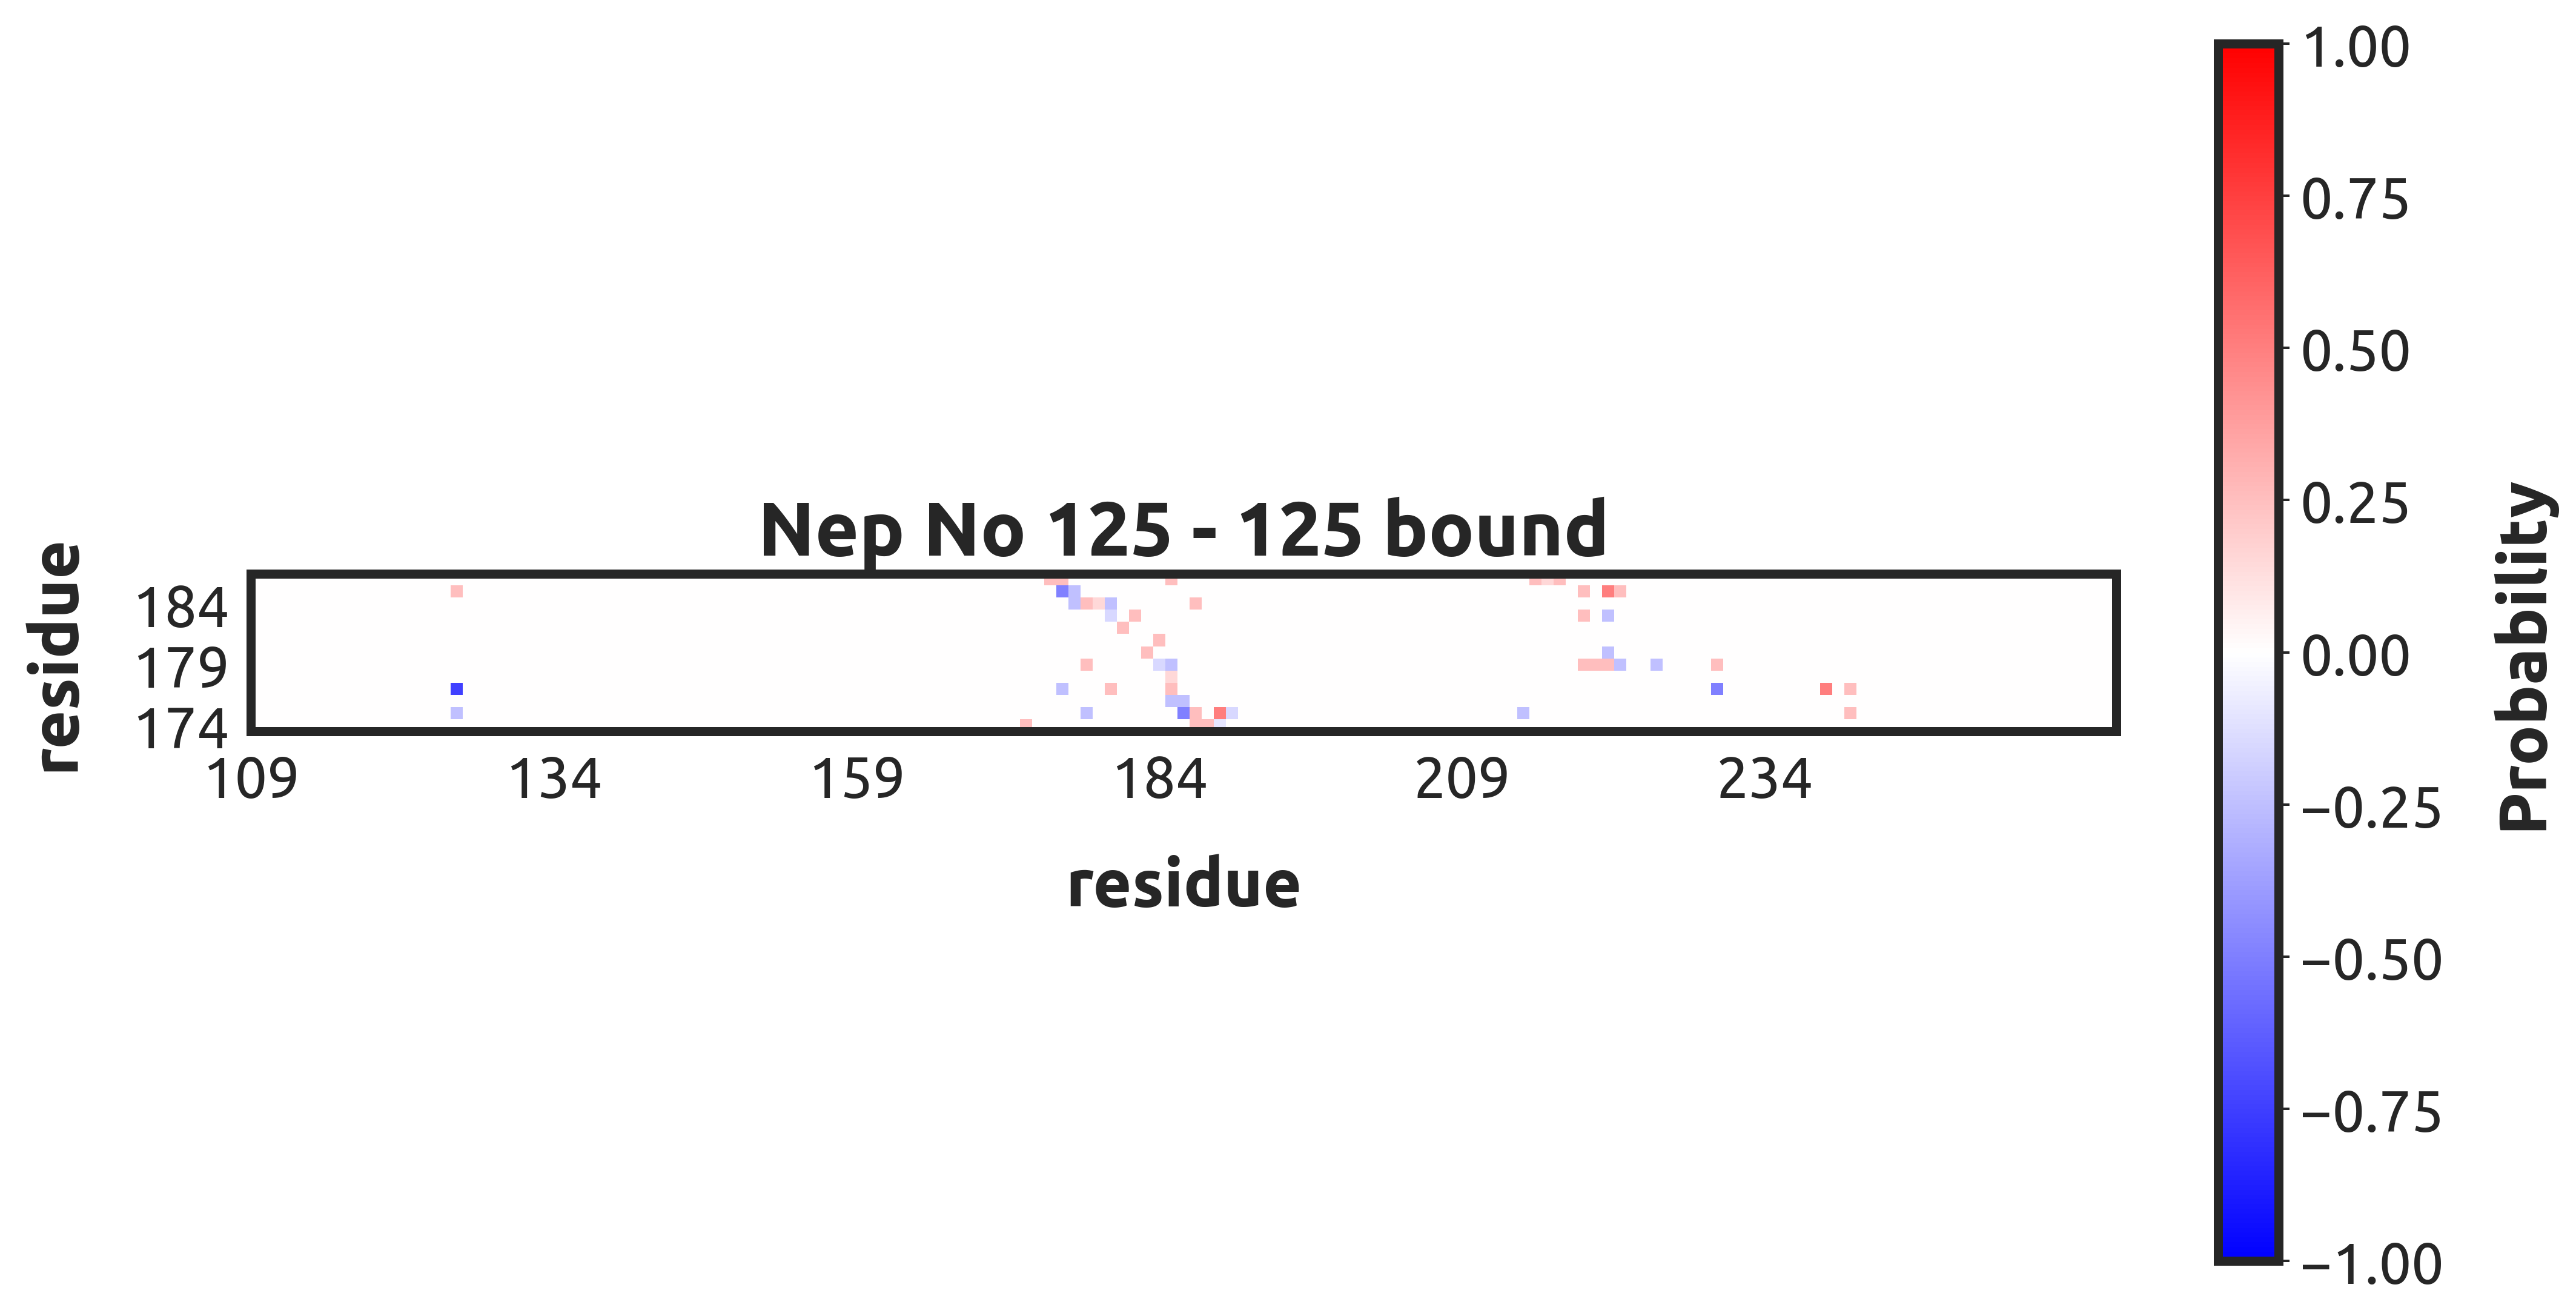

In [42]:
#What does the contact map look like?
fig,ax=plt.subplots(figsize=(12,15), dpi=360)

plt.imshow(nep_no_125_binned-nep_with_125_binned, origin='lower', cmap='bwr', vmin=-1, vmax=1)

plt.colorbar(fraction=0.03, label='Probability')

ax.xaxis.set_major_locator(MultipleLocator(25))
# ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.yaxis.set_major_locator(MultipleLocator(25))
# ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.xticks(ticks=range(26,170,25), labels=range(27+82,171+82,25));
plt.yticks(ticks=range(0,13,5), labels=range(174,187,5));
plt.xlim(26,180)

plt.title("Nep No 125 - 125 bound")

plt.ylabel('residue');
plt.xlabel('residue');

np.savetxt('./Figures/Lost_contacts.csv', nep_no_125_binned-nep_with_125_binned)
#Positive values reflect increased contacts when 125 bond is absent,
#Negative values reflect contacts that are decreased when 125 is gone.

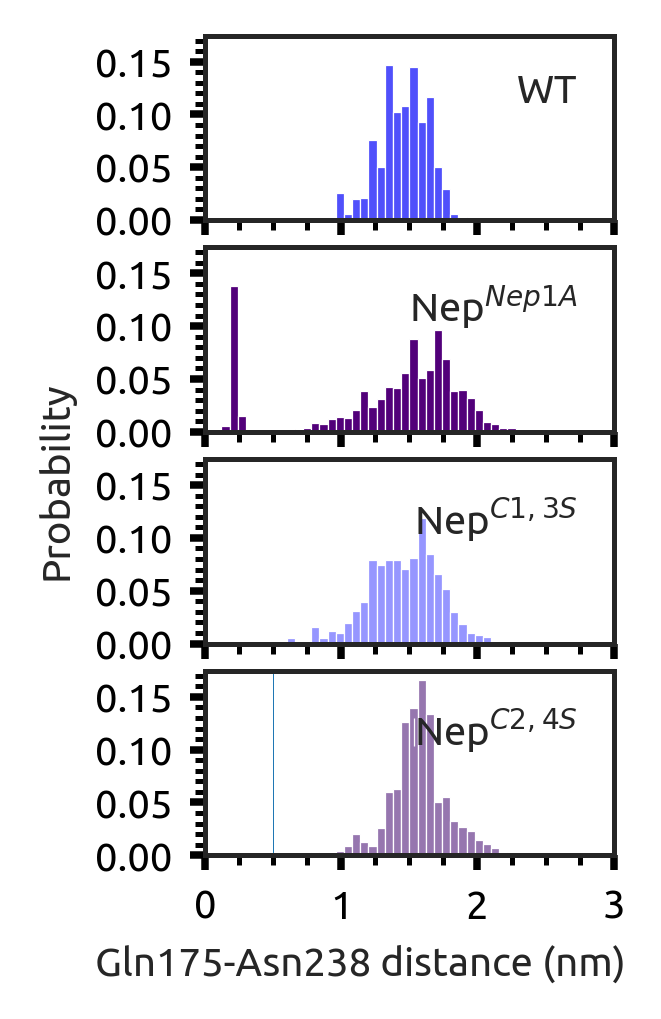

In [43]:
#Use the distance between E175 and N236 (WT) as loop flipping
wt_flip=calc_distance(centersWT,[[236],[175]],"sidechain","minn")
nep_flip=calc_distance(centersNep,[[177],[238]],"sidechain","minn")
ser1_flip=calc_distance(centersSer1,[[236],[175]],"sidechain","minn")
ser2_flip=calc_distance(centersSer2,[[236],[175]],"sidechain","minn")
# NepTruncFLAP=calc_distance(NepTruncTrjs,[[37],[97]],"protein")

numbins=50
min_val=0
max_val=3
countsWT, binsWT=np.histogram(wt_flip, bins=numbins,weights=popsWT, range=(min_val,max_val))
countsNep, bins=np.histogram(nep_flip, bins=numbins,weights=popsNep,range=(min_val,max_val))
countsSer1, bins=np.histogram(ser1_flip, bins=numbins,weights=popsSer1, range=(min_val,max_val))
countsSer2, bins=np.histogram(ser2_flip, bins=numbins,weights=popsSer2, range=(min_val,max_val))
# countsNepTrunc, bins=np.histogram(NepTruncFLAP, bins=50,range=(0.5,3.5))

normCountsWT= countsWT/sum(countsWT)
normCountsNep= countsNep/sum(countsNep)
normCountsSer1= countsSer1/sum(countsSer1)
normCountsSer2= countsSer2/sum(countsSer2)
# normCountsNepTrunc= countsNepTrunc/sum(countsNepTrunc)

binscenters_WT=(binsWT[:-1] + binsWT[1:]) / 2
width=binsWT[1]-binsWT[0]

fig, axs=plt.subplots(4,1,sharey=True, sharex=True,  figsize=(1.5, 2.5), dpi=360)
fig.text(-0.1, 0.5, 'Probability', va='center',rotation='vertical',fontsize=8)
fig.text(0.5, -0.05, 'Gln175-Asn238 distance (nm)', ha='center',fontsize=8)
plt.xlim(0,3)
axs[0].bar(binscenters_WT,normCountsWT, align='center', width=width, label="WT", color=wtc, linewidth=0.25)
axs[1].bar(binscenters_WT,normCountsNep, align='center', width=width, label="Nep$^{Nep1A}$", color=nepc, linewidth=0.25)
axs[2].bar(binscenters_WT,normCountsSer1, align='center', width=width, label="Nep$^{C1,3S}$", color=C13Sc, linewidth=0.25)
axs[3].bar(binscenters_WT,normCountsSer2, align='center', width=width, label="Nep$^{C2,4S}$", color=C24Sc, linewidth=0.25)

for ax in axs:
    ax.legend(fontsize=8,frameon=False, loc='upper right', handlelength=0, handletextpad=0, fancybox=True)
    ax.get_xticklabels()    
    ax.tick_params(which='major', direction='out', length=3, width=1.5, colors='black')
    ax.tick_params(which='minor', direction='out', length=2, width=1, colors='black')

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)    
    
    ax.tick_params(axis = 'x', which = 'both', bottom = True, top=False,labelsize=8)
    ax.tick_params(axis= 'y', which = 'both', left = True, right=False,labelsize=8)
fig.tight_layout(pad=0.05)
plt.axvline(x=0.5,lw=0.2)


# plt.savefig('./Figures/Loop_flipping_smaller.svg')
plt.show()

In [44]:
cutoff=0.5
wt_indcs=np.where(wt_flip>cutoff)
nep_indcs=np.where(nep_flip>cutoff)
s1_indcs=np.where(ser1_flip>cutoff)
s2_indcs=np.where(ser2_flip>cutoff)

wt_vals=[np.sum(bs_wt_pops[i][wt_indcs]) for i in range(len(bs_wt_pops))]
nep_vals=[np.sum(bs_nep_pops[i][nep_indcs]) for i in range(len(bs_nep_pops))]
s1_vals=[np.sum(bs_ser1_pops[i][s1_indcs]) for i in range(len(bs_ser1_pops))]
s2_vals=[np.sum(bs_ser2_pops[i][s2_indcs]) for i in range(len(bs_ser2_pops))]

print("WT Flipped Distal loop % is:", (100*np.mean(wt_vals)), "+/-", 100*np.std(wt_vals), "%")
print("Nep Mut Flipped Distal loop % is:", (100*np.mean(nep_vals)), "+/-", 100*np.std(nep_vals), "%")
print("Ser 1 Flipped Distal loop % is:", (100*np.mean(s1_vals)), "+/-", 100*np.std(s1_vals), "%")
print("Ser 2 Flipped Distal loop % is:", (100*np.mean(s2_vals)), "+/-", 100*np.std(s2_vals), "%")

WT Flipped Distal loop % is: 100.0 +/- 4.196248604251576e-15 %
Nep Mut Flipped Distal loop % is: 83.66266359771302 +/- 6.6249168867839785 %
Ser 1 Flipped Distal loop % is: 99.90669586362975 +/- 0.02917259186412124 %
Ser 2 Flipped Distal loop % is: 100.0 +/- 9.383097129595137e-15 %
